In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [67]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [68]:
batch_size = 100
learning_rate = 0.0002
num_epoch = 1

In [69]:
mnist_train = dset.MNIST("/content/drive/MyDrive", train=True, transform=transforms.ToTensor(), target_transform=None, download=False)
mnist_test = dset.MNIST("/content/drive/MyDrive", train=False, transform=transforms.ToTensor(), target_transform=None, download=False)

In [70]:
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)

In [71]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder,self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(1,16,3,padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Conv2d(16,32,3,padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Conv2d(32,64,3,padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2,2)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(64,128,3,padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(2,2),
        nn.Conv2d(128,256,3,padding=1),
        nn.ReLU()
    )

  def forward(self,x):
    # print(x.size())
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.view(batch_size,-1)
    return out

encoder = Encoder().cuda()

In [72]:
class Decoder(nn.Module):
  def __init__(self):
    super(Decoder,self).__init__()
    self.layer1 = nn.Sequential(
        nn.ConvTranspose2d(256,128,3,2,1,1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.ConvTranspose2d(128,64,3,1,1),
        nn.ReLU(),
        nn.BatchNorm2d(64)
    )
    self.layer2 = nn.Sequential(
        nn.ConvTranspose2d(64,16,3,1,1),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.ConvTranspose2d(16,1,3,2,1,1),
        nn.ReLU()
    )

  def forward(self,x):
    out = x.view(batch_size,256,7,7)
    out = self.layer1(out)
    out = self.layer2(out)
    return out

decoder = Decoder().cuda()

    #중간중간 size 출력?

In [73]:
parameters = list(encoder.parameters()) + list(decoder.parameters())
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)

In [74]:
# try:
#   encoder, decoder = torch.load('./model/conv_deno_autoencoder.pkl')
#   print("\n---------model restored---------\n")
# except:
#   print("\n---------model not restored---------\n")
#   pass

for i in range(num_epoch):
  for j,[image,label] in enumerate(train_loader):
    noise = init.normal_(torch.FloatTensor(batch_size,1,28,28),0,0.1)
    noise = noise.cuda()

    optimizer.zero_grad()

    image = image.cuda()
    noise_image = image + noise
    output = encoder(noise_image)
    output = decoder(output)
    loss = loss_func(output,image)

    loss.backward()
    optimizer.step()

    if j % 10 == 0:
      print(loss)
      torch.save([encoder,decoder], './model/conv_deno_autoencoder.pkl')

tensor(0.5181, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.1082, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0673, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0503, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0390, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0313, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0261, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0228, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0200, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0177, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0163, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0154, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0138, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward

torch.Size([100, 28, 28])


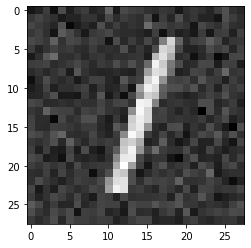

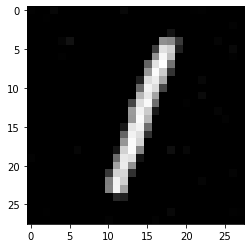

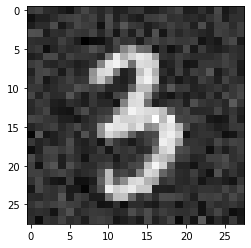

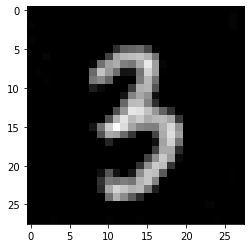

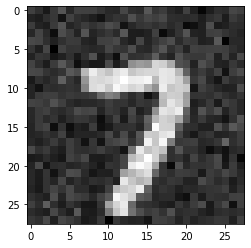

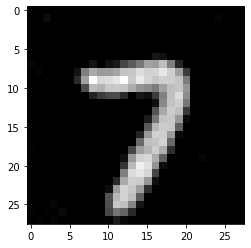

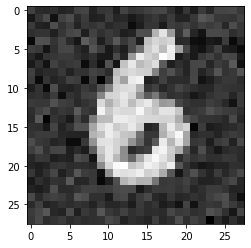

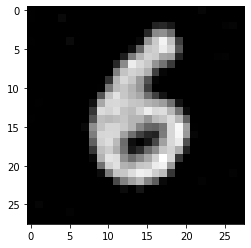

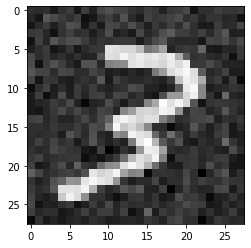

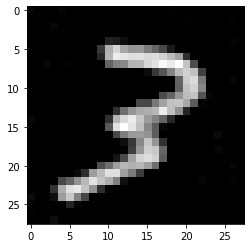

In [75]:
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(5):
  plt.imshow(torch.squeeze(noise_image.cpu().data[i]).numpy(), cmap='gray')
  plt.show()
  plt.imshow(out_img[i].numpy(), cmap='gray')
  plt.show()

In [79]:
noise = init.normal(torch.FloatTensor(batch_size,1,28,28),0,0.1)
noise = noise.cuda()

for i in range(1):
  for j,[image,label] in enumerate(test_loader):
    image = image.cuda()
    noise_image = image + noise
    output = encoder(noise_image)
    output = decoder(output)
    loss = loss_func(output,image)

    if j % 10 == 0:
      print(loss)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  """Entry point for launching an IPython kernel.


tensor(0.0044, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0048, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0044, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0049, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0049, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0051, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward>)


torch.Size([100, 28, 28])


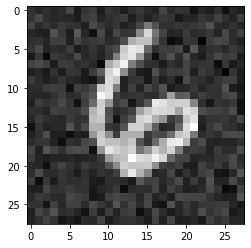

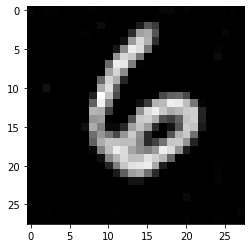

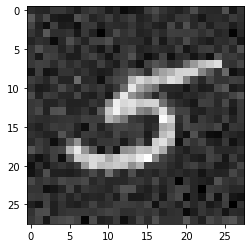

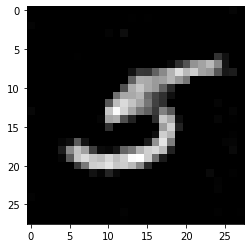

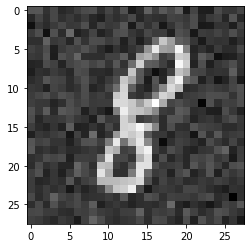

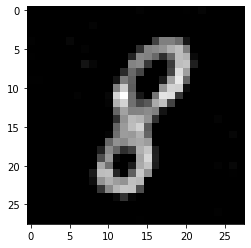

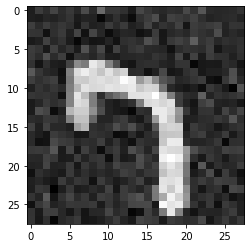

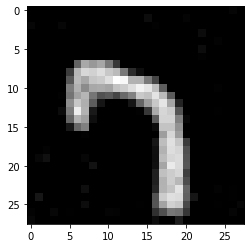

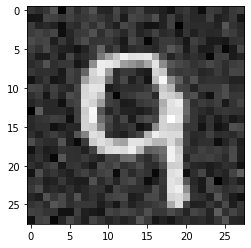

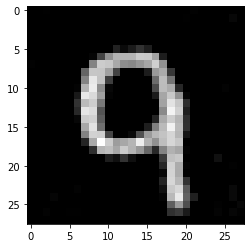

In [80]:
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(5):
  plt.imshow(torch.squeeze(noise_image.cpu().data[i]).numpy(), cmap='gray')
  plt.show()
  plt.imshow(out_img[i].numpy(), cmap='gray')
  plt.show()